In [1]:

import warnings
from pathlib import Path
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import lightgbm as lgb
from mlforecast import MLForecast
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

RNG_SEED = 2025
np.random.seed(RNG_SEED)

In [2]:
DATA = Path("/teamspace/studios/this_studio/data/dengue")
INTERIM = DATA/"interim"
FEATURES = DATA/"features"
REPORTS = DATA/"reports"
MODELS = DATA/"models"
for folder in [REPORTS, MODELS]:
    folder.mkdir(parents=True, exist_ok=True)

feature_path = FEATURES/"feature_matrix_weekly.parquet"
coords_path = INTERIM/"district_coords.csv"

assert feature_path.exists(), f"missing {feature_path}"
assert coords_path.exists(), f"missing {coords_path}"

df = pd.read_parquet(feature_path).copy()
coords = pd.read_csv(coords_path).drop_duplicates("district_id_txt_clean")

print("Weekly feature matrix:", df.shape)
print("Coords table:", coords.shape)
print("Week span:", df["week_start"].min(), "→", df["week_start"].max())
print("Districts:", df["district_id_txt_clean"].nunique())
df.head(3)

Weekly feature matrix: (21369, 94)
Coords table: (76, 3)
Week span: 2018-01-08 00:00:00 → 2024-05-27 00:00:00
Districts: 71


,district_id_txt_clean,week_start,cases,ipd_rate,fatal_rate,age_mean,district_num,province_code,temperature_2m_mean,temperature_2m_min,...,temperature_2m_mean_roll8_mean,temperature_2m_mean_roll8_sum,temperature_2m_mean_roll12_mean,temperature_2m_mean_roll12_sum,vpd_kpa_roll4_mean,vpd_kpa_roll4_sum,vpd_kpa_roll8_mean,vpd_kpa_roll8_sum,vpd_kpa_roll12_mean,vpd_kpa_roll12_sum
0,None|ปทุมธานี,2023-04-10,0,0.0,0.0,0.0,1312,3,27.8,24.414286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None|ปทุมธานี,2023-04-17,0,0.0,0.0,0.0,1312,3,27.8,24.414286,...,NaN,NaN,NaN,NaN,0.983104,1.966208,NaN,NaN,NaN,NaN
2,None|ปทุมธานี,2023-04-24,0,0.0,0.0,0.0,1312,3,27.8,24.414286,...,NaN,NaN,NaN,NaN,0.983104,2.949312,NaN,NaN,NaN,NaN


In [3]:
from sklearn.neighbors import NearestNeighbors

df = df.sort_values(["district_id_txt_clean","week_start"]).copy()
df["week_start"] = pd.to_datetime(df["week_start"])

extra_lags = [16, 20, 24]
extra_rolls = [6, 10, 16]
diff_windows = [1, 4]

def enhance_group(g: pd.DataFrame) -> pd.DataFrame:
    g = g.sort_values("week_start").copy()
    for lag in extra_lags:
        g[f"cases_lag{lag}"] = g["cases"].shift(lag)
    for window in extra_rolls:
        g[f"cases_roll{window}_mean"] = g["cases"].rolling(window, min_periods=max(1, window//2)).mean().shift(1)
        g[f"cases_roll{window}_sum"] = g["cases"].rolling(window, min_periods=max(1, window//2)).sum().shift(1)
    g["cases_ema4"] = g["cases"].ewm(span=4, adjust=False).mean().shift(1)
    g["cases_ema8"] = g["cases"].ewm(span=8, adjust=False).mean().shift(1)
    g["cases_volatility8"] = g["cases"].rolling(8, min_periods=4).std().shift(1)
    for w in diff_windows:
        prev_cases = g["cases"].shift(1)
        baseline = g["cases"].shift(w + 1)
        g[f"cases_diff{w}"] = prev_cases - baseline
        g[f"cases_pct_change{w}"] = (prev_cases - baseline) / (baseline + 1e-3)
    prev_cases = g["cases"].shift(1)
    prev_prev_cases = g["cases"].shift(2)
    g["cases_ratio1"] = prev_cases / (prev_prev_cases + 1e-3)
    return g

df = df.groupby("district_id_txt_clean", group_keys=False).apply(enhance_group)

df = df.merge(coords[["district_id_txt_clean","lat","lon"]], on="district_id_txt_clean", how="left")
df["lat"] = df["lat"].fillna(df["lat"].mean())
df["lon"] = df["lon"].fillna(df["lon"].mean())

scaler = StandardScaler()
coord_scaled = scaler.fit_transform(df.drop_duplicates("district_id_txt_clean")[['lat','lon']])
n_clusters = min(6, df["district_id_txt_clean"].nunique())
kmeans = KMeans(n_clusters=n_clusters, random_state=RNG_SEED, n_init=20)
cluster_labels = kmeans.fit_predict(coord_scaled)
cluster_map = dict(zip(df.drop_duplicates("district_id_txt_clean")["district_id_txt_clean"], cluster_labels))
df["cluster_id"] = df["district_id_txt_clean"].map(cluster_map).astype(int)

cluster_stats = (df.groupby(["cluster_id","week_start"], as_index=False)["cases"]
                  .mean().rename(columns={"cases":"cluster_cases_mean_raw"}))
df = df.merge(cluster_stats, on=["cluster_id","week_start"], how="left")
df["cluster_cases_mean"] = df.groupby("cluster_id")["cluster_cases_mean_raw"].shift(1)
df["cluster_cases_lag1"] = df.groupby("cluster_id")["cluster_cases_mean"].shift(1)
df["cluster_cases_lag4"] = df.groupby("cluster_id")["cluster_cases_mean"].shift(4)
cluster_std = df.groupby("cluster_id")["cases"].transform(lambda x: x.std(ddof=0) + 1e-3)
prev_cases = df.groupby("cluster_id")["cases"].shift(1)
df["cases_zscore_cluster"] = (prev_cases - df["cluster_cases_mean"]) / cluster_std
df = df.drop(columns=["cluster_cases_mean_raw"])
df["cases_zscore_cluster"] = df["cases_zscore_cluster"].replace([np.inf, -np.inf], np.nan)

req_cols = ["cases_lag1","cases_lag2","cases_lag3"] + [f"cases_lag{lag}" for lag in extra_lags]
cluster_cols = ["cluster_cases_mean","cluster_cases_lag1","cluster_cases_lag4","cases_zscore_cluster"]
req_cols = [c for c in req_cols if c in df.columns] + [c for c in cluster_cols if c in df.columns]
df = df.dropna(subset=req_cols).reset_index(drop=True)

print("Enhanced feature set shape:", df.shape)
df.head(3)

Enhanced feature set shape: (19665, 118)


,district_id_txt_clean,week_start,cases,ipd_rate,fatal_rate,age_mean,district_num,province_code,temperature_2m_mean,temperature_2m_min,...,cases_diff4,cases_pct_change4,cases_ratio1,lat,lon,cluster_id,cluster_cases_mean,cluster_cases_lag1,cluster_cases_lag4,cases_zscore_cluster
0,None|ปทุมธานี,2023-09-25,1,0.0,0.0,19.61347,1327,3,27.8,24.414286,...,0.0,0.0,0.0,14.498458,100.662091,5,2.000000,2.411765,3.176471,-1.074210
1,None|ปทุมธานี,2023-10-02,0,0.0,0.0,0.00000,1327,3,27.8,24.414286,...,0.0,0.0,1000.0,14.498458,100.662091,5,2.176471,2.000000,1.764706,-0.631888
2,None|ปทุมธานี,2023-10-09,0,0.0,0.0,0.00000,1327,3,27.8,24.414286,...,0.0,0.0,0.0,14.498458,100.662091,5,1.470588,2.176471,1.529412,-0.789860


In [4]:
cluster_stats

,cluster_id,week_start,cluster_cases_mean_raw
0,0,2018-01-08,0.0
1,0,2018-01-15,0.0
2,0,2018-01-22,0.0
3,0,2018-01-29,0.0
4,0,2018-02-05,0.0
...,...,...,...
1901,5,2024-03-04,0.0
1902,5,2024-03-11,0.0
1903,5,2024-03-18,0.0
1904,5,2024-03-25,0.0


In [5]:
df_ml = df.rename(columns={
    "district_id_txt_clean": "unique_id",
    "week_start": "ds",
    "cases": "y"
}).copy()

df_ml["ds"] = pd.to_datetime(df_ml["ds"])
df_ml["y"] = pd.to_numeric(df_ml["y"], errors="coerce").clip(lower=0)

df_ml["year"] = df_ml["ds"].dt.year.astype(int)
df_ml["month"] = df_ml["ds"].dt.month.astype(int)
df_ml["weekofyear"] = df_ml["ds"].dt.isocalendar().week.astype(int)
df_ml["sin_woy"] = np.sin(2 * np.pi * df_ml["weekofyear"] / 52.0)
df_ml["cos_woy"] = np.cos(2 * np.pi * df_ml["weekofyear"] / 52.0)

static_candidates = ["province_code","district_num","cluster_id"]
STATIC_FEATS = []
EXCLUDED_STATIC = []
for col in static_candidates:
    if col in df_ml.columns:
        nunique_per_id = df_ml.groupby("unique_id")[col].nunique(dropna=False).max()
        if nunique_per_id == 1:
            STATIC_FEATS.append(col)
        else:
            EXCLUDED_STATIC.append(col)

DATE_FEATS = ["year","month","weekofyear","sin_woy","cos_woy"]
EXOG_FEATS = [c for c in [
    "temperature_2m_mean","temperature_2m_min","temperature_2m_max",
    "relative_humidity_2m_mean","dewpoint_2m_mean","vpd_kpa",
    "precipitation_sum","rain_sum","shortwave_radiation_sum","windspeed_10m_max",
    "ipd_rate","fatal_rate","age_mean"
] if c in df_ml.columns]

base_feature_cols = {"unique_id","ds","y"}
extra_feature_cols = sorted(
    c for c in df_ml.columns
    if c not in base_feature_cols
    and c not in STATIC_FEATS
    and c not in DATE_FEATS
    and c not in EXOG_FEATS
)
XCOLS = list(dict.fromkeys(STATIC_FEATS + DATE_FEATS + EXOG_FEATS + extra_feature_cols))

print("Static features:", STATIC_FEATS)
if EXCLUDED_STATIC:
    print("Excluded from static due to variability:", EXCLUDED_STATIC)
print("Date features:", DATE_FEATS)
print("Exogenous features:", len(EXOG_FEATS))
print("Extra engineered features:", len(extra_feature_cols))
print("Total predictors:", len(XCOLS))
df_ml[["unique_id","ds","y"] + XCOLS].head(3)

Static features: ['province_code', 'cluster_id']
Excluded from static due to variability: ['district_num']
Date features: ['year', 'month', 'weekofyear', 'sin_woy', 'cos_woy']
Exogenous features: 13
Extra engineered features: 96
Total predictors: 116


,unique_id,ds,y,province_code,cluster_id,year,month,weekofyear,sin_woy,cos_woy,...,vpd_kpa_roll4_mean,vpd_kpa_roll4_sum,vpd_kpa_roll8_mean,vpd_kpa_roll8_sum,windspeed_10m_max_lag1,windspeed_10m_max_lag12,windspeed_10m_max_lag2,windspeed_10m_max_lag3,windspeed_10m_max_lag4,windspeed_10m_max_lag8
0,None|ปทุมธานี,2023-09-25,1,3,5,2023,9,39,-1.000000,-1.836970e-16,...,0.983104,3.932416,0.983104,7.864832,12.957143,12.957143,12.957143,12.957143,12.957143,12.957143
1,None|ปทุมธานี,2023-10-02,0,3,5,2023,10,40,-0.992709,1.205367e-01,...,0.983104,3.932416,0.983104,7.864832,12.957143,12.957143,12.957143,12.957143,12.957143,12.957143
2,None|ปทุมธานี,2023-10-09,0,3,5,2023,10,41,-0.970942,2.393157e-01,...,0.983104,3.932416,0.983104,7.864832,12.957143,12.957143,12.957143,12.957143,12.957143,12.957143


In [6]:
df_ml = df_ml.sort_values(["ds","unique_id"]).reset_index(drop=True)

last_weeks = 26
unique_ds = df_ml["ds"].drop_duplicates().sort_values()
cut_date = unique_ds.iloc[-last_weeks]
print("Validation start date:", cut_date.date())

train_mask = df_ml["ds"] < cut_date
valid_mask = df_ml["ds"] >= cut_date

df_train = df_ml.loc[train_mask].copy()
df_valid = df_ml.loc[valid_mask].copy()

print("Train rows:", len(df_train), "| Valid rows:", len(df_valid))
print("Train weeks:", df_train['ds'].nunique(), "| Valid weeks:", df_valid['ds'].nunique())
print("Validation districts:", df_valid['unique_id'].nunique())

Validation start date: 2023-12-04
Train rows: 19456 | Valid rows: 209
Train weeks: 284 | Valid weeks: 26
Validation districts: 59


In [7]:
lgbm_poisson = lgb.LGBMRegressor(
    objective="poisson",
    metric="rmse",
    n_estimators=1800,
    learning_rate=0.035,
    num_leaves=120,
    min_child_samples=55,
    subsample=0.9,
    subsample_freq=1,
    colsample_bytree=0.85,
    reg_alpha=0.2,
    reg_lambda=1.6,
    poisson_max_delta_step=0.7,
    random_state=RNG_SEED,
    n_jobs=-1
 )

fcst = MLForecast(
    models={"lgb_poisson": lgbm_poisson},
    freq="W-MON",
    lags=None,
    lag_transforms=None,
    date_features=None,
    num_threads=1
)

static_feats = [c for c in STATIC_FEATS if c in df_train.columns]
train_fit = df_train[["unique_id","ds","y"] + XCOLS].copy()
train_fit["y"] = train_fit["y"].astype(float)

fcst.fit(
    df=train_fit,
    id_col="unique_id",
    time_col="ds",
    target_col="y",
    static_features=static_feats if len(static_feats) else None
)

print("Fitted models:", list(fcst.models_.keys()))
print("Static features used:", static_feats)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22281
[LightGBM] [Info] Number of data points in the train set: 19456, number of used features: 115
[LightGBM] [Info] Start training from score -0.314702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Top feature importances (average gain):
                              avg_importance
age_mean                       467136.811883
ipd_rate                        54832.704845
cases_ema4                      34108.323019
cases_ema8                      30096.462565
cases_roll6_mean                14635.336789
cases_roll4_mean                 6246.624615
cases_volatility8                1844.924405
cases_zscore_cluster             1579.860562
temperature_2m_mean_lag8         1503.315138
temperature_2m_mean_lag12        1167.421084
cluster_cases_lag4                994.408435
lon                               987.332680
cluster_cases_mean                942.916467
cases_lag4                        936.833405
precipitation_sum_lag4            855.871720
cases_lag1                        798.704182
cluster_cases_lag1                796.220696
lat                               766.636975
windspeed_10m_max_lag8            749.438377
shortwave_radiation_sum_lag8      742.048382


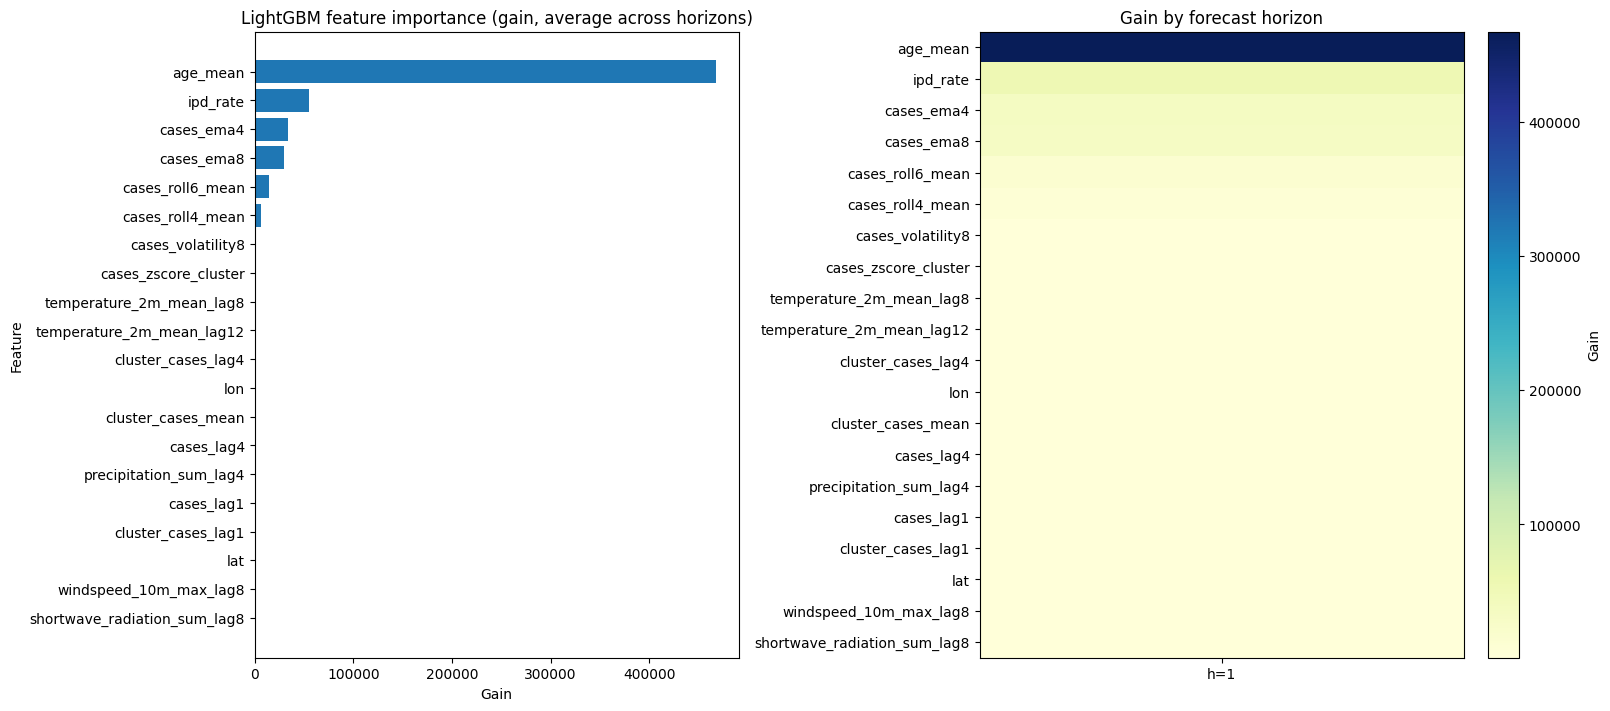

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numbers import Integral

model_registry = getattr(fcst, "models_", None)
if model_registry is None:
    model_registry = getattr(fcst, "models", None)
if model_registry is None:
    raise ValueError("No fitted models found on MLForecast object. Run the fit cell before this one.")

importance_container = model_registry.get("lgb_poisson") if isinstance(model_registry, dict) else None
if importance_container is None:
    raise ValueError("LightGBM model 'lgb_poisson' not found. Make sure to run the fit cell first.")

if isinstance(importance_container, dict):
    horizon_items = sorted(importance_container.items(), key=lambda kv: kv[0])
    horizon_labels: list[str] = []
    models_for_importance: list = []
    for key, model in horizon_items:
        horizon_labels.append(f"h={int(key)}" if isinstance(key, Integral) else str(key))
        models_for_importance.append(model)
elif isinstance(importance_container, (list, tuple)):
    models_for_importance = list(importance_container)
    horizon_labels = [f"h={idx + 1}" for idx in range(len(models_for_importance))]
else:
    models_for_importance = [importance_container]
    horizon_labels = ["h=1"]

importance_series = []
for label, model in zip(horizon_labels, models_for_importance):
    booster = getattr(model, "booster_", None) or getattr(model, "_Booster", None)
    if booster is None:
        raise ValueError(f"LightGBM model for {label} does not expose a booster_.")
    feature_names = booster.feature_name()
    gains = booster.feature_importance(importance_type="gain")
    importance_series.append(pd.Series(gains, index=feature_names, name=label))

importance_table = pd.concat(importance_series, axis=1).fillna(0)
importance_table["avg_importance"] = importance_table.mean(axis=1)
importance_table = importance_table.sort_values("avg_importance", ascending=False)

top_k = min(20, len(importance_table))
top_importance = importance_table.head(top_k)

print("Top feature importances (average gain):")
print(top_importance[["avg_importance"]])

fig, axes = plt.subplots(1, 2, figsize=(16, max(6, top_k * 0.35)), constrained_layout=True)

axes[0].barh(top_importance.index[::-1], top_importance["avg_importance"][::-1], color="tab:blue")
axes[0].set_title("LightGBM feature importance (gain, average across horizons)")
axes[0].set_xlabel("Gain")
axes[0].set_ylabel("Feature")

heat_data = top_importance[horizon_labels]
im = axes[1].imshow(heat_data.to_numpy(), aspect="auto", cmap="YlGnBu")
axes[1].set_title("Gain by forecast horizon")
axes[1].set_xticks(np.arange(len(horizon_labels)))
axes[1].set_xticklabels(horizon_labels)
axes[1].set_yticks(np.arange(heat_data.shape[0]))
axes[1].set_yticklabels(top_importance.index)
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label("Gain")

plt.show()

In [9]:
model_registry = getattr(fcst, "models_", None) or getattr(fcst, "models", None)
print(type(model_registry))
print(model_registry.keys())
container = model_registry.get("lgb_poisson")
print(type(container))
if isinstance(container, dict):
    first_model = next(iter(container.values()))
elif isinstance(container, (list, tuple)) and len(container):
    first_model = container[0]
else:
    first_model = container
print(type(first_model))
print([attr for attr in dir(first_model) if "boost" in attr.lower() or "model" in attr.lower()])
print("booster attr:", getattr(first_model, "booster_", None))

<class 'dict'>
dict_keys(['lgb_poisson'])
<class 'lightgbm.sklearn.LGBMRegressor'>
<class 'lightgbm.sklearn.LGBMRegressor'>
['_Booster', 'booster_', 'boosting_type']
booster attr: <lightgbm.basic.Booster object at 0x792e35f35f70>


In [10]:
train_fit

,unique_id,ds,y,province_code,cluster_id,year,month,weekofyear,sin_woy,cos_woy,...,vpd_kpa_roll4_mean,vpd_kpa_roll4_sum,vpd_kpa_roll8_mean,vpd_kpa_roll8_sum,windspeed_10m_max_lag1,windspeed_10m_max_lag12,windspeed_10m_max_lag2,windspeed_10m_max_lag3,windspeed_10m_max_lag4,windspeed_10m_max_lag8
0,คลองหลวง|ปทุมธานี,2018-06-25,0.0,3,2,2018,6,26,-3.216245e-16,-1.000000,...,0.876562,3.506249,0.772932,6.183457,15.371429,14.742857,19.771429,17.757143,11.000000,12.414286
1,ค่ายบางระจัน|สิงห์บุรี,2018-06-25,0.0,7,4,2018,6,26,-3.216245e-16,-1.000000,...,1.128154,4.512615,1.013407,8.107259,18.714286,14.542857,23.200000,20.271429,11.757143,11.600000
2,ชัยบาดาล|ลพบุรี,2018-06-25,0.0,5,3,2018,6,26,-3.216245e-16,-1.000000,...,0.778331,3.113326,0.802435,6.419477,17.257143,16.642857,21.842857,19.542857,10.757143,11.671429
3,ดอนพุด|สระบุรี,2018-06-25,0.0,6,5,2018,6,26,-3.216245e-16,-1.000000,...,0.973920,3.895681,0.903740,7.229922,15.900000,14.442857,20.571429,18.071429,11.657143,12.528571
4,ท่าช้าง|สิงห์บุรี,2018-06-25,0.0,7,4,2018,6,26,-3.216245e-16,-1.000000,...,1.072068,4.288273,0.988705,7.909644,18.285714,14.728571,21.985714,19.371429,11.385714,12.942857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19451,แสวงหา|อ่างทอง,2023-11-27,0.0,8,4,2023,11,48,-4.647232e-01,0.885456,...,0.977757,3.911027,0.816562,6.532495,17.685714,14.471429,20.171429,11.928571,15.314286,12.871429
19452,โคกสำโรง|ลพบุรี,2023-11-27,1.0,5,1,2023,11,48,-4.647232e-01,0.885456,...,0.975826,3.903303,0.802930,6.423440,17.900000,13.257143,21.871429,10.985714,13.814286,11.785714
19453,โคกเจริญ|ลพบุรี,2023-11-27,0.0,5,1,2023,11,48,-4.647232e-01,0.885456,...,0.911587,3.646349,0.758835,6.070681,16.128571,13.514286,20.457143,11.342857,12.700000,12.842857
19454,ไชโย|อ่างทอง,2023-11-27,0.0,8,4,2023,11,48,-4.647232e-01,0.885456,...,0.898718,3.594874,0.755340,6.042724,17.685714,15.242857,20.014286,12.814286,14.314286,10.671429


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21820
[LightGBM] [Info] Number of data points in the train set: 18466, number of used features: 115
[LightGBM] [Info] Start training from score -0.482406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,h,RMSE,MAE,RMSLE,WAPE,R2
0,h=1,2.11561,1.074935,0.278887,34.842712,0.770093
1,h=2,1.430686,0.677349,0.234416,35.11259,0.76252


Saved cross-validation metrics → /teamspace/studios/this_studio/data/dengue/reports/phase2_cv_metrics_v2.csv


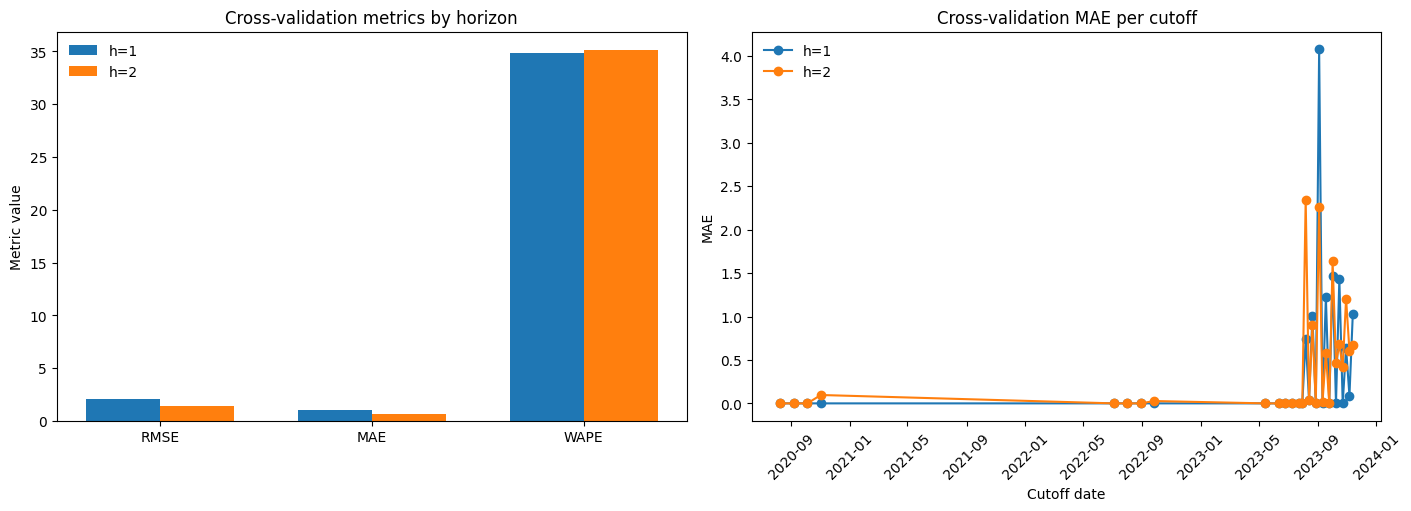

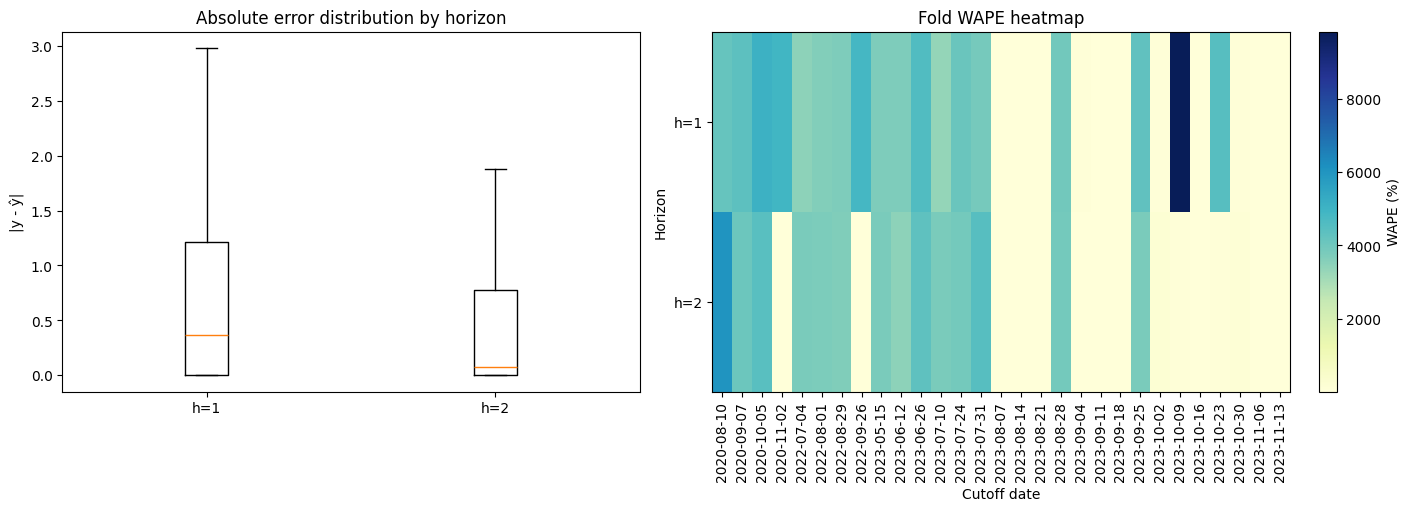

In [11]:
N_WINDOWS = 4
STEP_SIZE = 4
H = 2

cv_preds = fcst.cross_validation(
    df=df_train[["unique_id","ds","y"] + XCOLS],
    h=H,
    n_windows=N_WINDOWS,
    step_size=STEP_SIZE,
    refit=True,
    id_col="unique_id",
    time_col="ds",
    target_col="y",
    static_features=static_feats if len(static_feats) else None,
    dropna=True
)

if "Forecast" in cv_preds.columns:
    forecast_col = "Forecast"
elif "lgb_poisson" in cv_preds.columns:
    forecast_col = "lgb_poisson"
else:
    numeric_cols = [c for c in cv_preds.columns if c not in ["unique_id","ds","y","cutoff","origin"] and pd.api.types.is_numeric_dtype(cv_preds[c])]
    assert len(numeric_cols), "No numeric prediction column found"
    forecast_col = numeric_cols[0]

cv_preds[forecast_col] = cv_preds[forecast_col].clip(lower=0)

if "cutoff" not in cv_preds.columns and "origin" in cv_preds.columns:
    cv_preds["cutoff"] = pd.to_datetime(cv_preds["origin"])
cv_preds["ds"] = pd.to_datetime(cv_preds["ds"])
cv_preds["cutoff"] = pd.to_datetime(cv_preds["cutoff"])
cv_preds["h"] = ((cv_preds["ds"] - cv_preds["cutoff"]).dt.days // 7).astype(int)
cv_preds.loc[cv_preds["h"] < 1, "h"] = 1

def summarize_metrics(frame: pd.DataFrame, label: str) -> pd.Series:
    y = frame["y"].to_numpy(dtype=float)
    yhat = frame[forecast_col].to_numpy(dtype=float)
    rmse = float(np.sqrt(np.mean((yhat - y)**2)))
    mae = float(np.mean(np.abs(yhat - y)))
    rmsle = float(np.sqrt(np.mean((np.log1p(np.maximum(yhat, 0)) - np.log1p(np.maximum(y, 0)))**2)))
    denom = float(np.abs(y).sum()) + 1e-6
    wape = float(np.abs(yhat - y).sum() / denom * 100)
    if np.allclose(y.var(), 0):
        r2 = np.nan
    else:
        ss_res = float(((y - yhat)**2).sum())
        ss_tot = float(((y - y.mean())**2).sum())
        r2 = float(1 - ss_res / (ss_tot + 1e-12))
    return pd.Series({"h": label, "RMSE": rmse, "MAE": mae, "RMSLE": rmsle, "WAPE": wape, "R2": r2})

cv_summary = pd.concat([
    summarize_metrics(cv_preds[cv_preds["h"] == 1], "h=1"),
    summarize_metrics(cv_preds[cv_preds["h"] == 2], "h=2"),
], axis=1).T.reset_index(drop=True)

display(cv_summary)

cv_out = REPORTS/"phase2_cv_metrics_v2.csv"
cv_summary.to_csv(cv_out, index=False)
print("Saved cross-validation metrics →", cv_out)

import matplotlib.pyplot as plt

metrics_to_plot = ["RMSE","MAE","WAPE"]
x_pos = np.arange(len(metrics_to_plot))
width = 0.35
h1_vals = cv_summary.loc[cv_summary["h"] == "h=1", metrics_to_plot].to_numpy().ravel()
h2_vals = cv_summary.loc[cv_summary["h"] == "h=2", metrics_to_plot].to_numpy().ravel()

fold_records = []
for (cutoff, h_val), sub in cv_preds.groupby(["cutoff","h"]):
    y = sub["y"].to_numpy(dtype=float)
    yhat = sub[forecast_col].to_numpy(dtype=float)
    mae = float(np.mean(np.abs(yhat - y)))
    denom = float(np.abs(y).sum()) + 1e-6
    wape = float(np.abs(yhat - y).sum() / denom * 100)
    fold_records.append({"cutoff": pd.to_datetime(cutoff), "h": int(h_val), "MAE": mae, "WAPE": wape})
fold_metrics = pd.DataFrame(fold_records).sort_values("cutoff")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

axes[0].bar(x_pos - width/2, h1_vals, width, label="h=1")
axes[0].bar(x_pos + width/2, h2_vals, width, label="h=2")
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].set_ylabel("Metric value")
axes[0].set_title("Cross-validation metrics by horizon")
axes[0].legend(frameon=False)

for h_val in sorted(fold_metrics["h"].unique()):
    sub = fold_metrics[fold_metrics["h"] == h_val]
    axes[1].plot(sub["cutoff"], sub["MAE"], marker="o", linewidth=1.5, label=f"h={h_val}")
axes[1].set_title("Cross-validation MAE per cutoff")
axes[1].set_xlabel("Cutoff date")
axes[1].set_ylabel("MAE")
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend(frameon=False)

plt.show()

cv_preds["abs_error"] = np.abs(cv_preds[forecast_col] - cv_preds["y"])
cv_preds["squared_error"] = (cv_preds[forecast_col] - cv_preds["y"])**2

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

box_data = [cv_preds.loc[cv_preds["h"] == h_val, "abs_error"].dropna().to_numpy() for h_val in sorted(cv_preds["h"].unique())]
axes[0].boxplot(box_data, labels=[f"h={h_val}" for h_val in sorted(cv_preds["h"].unique())], showfliers=False)
axes[0].set_title("Absolute error distribution by horizon")
axes[0].set_ylabel("|y - ŷ|")

heat_df = fold_metrics.pivot_table(index="h", columns="cutoff", values="WAPE")
im = axes[1].imshow(heat_df, aspect="auto", cmap="YlGnBu")
axes[1].set_title("Fold WAPE heatmap")
axes[1].set_xlabel("Cutoff date")
axes[1].set_ylabel("Horizon")
axes[1].set_xticks(np.arange(len(heat_df.columns)))
axes[1].set_xticklabels([d.strftime("%Y-%m-%d") for d in heat_df.columns], rotation=90)
axes[1].set_yticks(np.arange(len(heat_df.index)))
axes[1].set_yticklabels([f"h={int(h_val)}" for h_val in heat_df.index])
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label("WAPE (%)")

plt.show()

In [12]:
df_all = pd.concat([df_train, df_valid], ignore_index=True)

cv_full = fcst.cross_validation(
    df=df_all[["unique_id","ds","y"] + XCOLS],
    h=H,
    n_windows=5,
    step_size=4,
    refit=True,
    id_col="unique_id",
    time_col="ds",
    target_col="y",
    static_features=static_feats if len(static_feats) else None,
    dropna=True
)

pred_col = "Forecast" if "Forecast" in cv_full.columns else forecast_col
cv_full[pred_col] = cv_full[pred_col].clip(lower=0)

if "cutoff" not in cv_full.columns and "origin" in cv_full.columns:
    cv_full["cutoff"] = pd.to_datetime(cv_full["origin"])
cv_full["ds"] = pd.to_datetime(cv_full["ds"])
cv_full["cutoff"] = pd.to_datetime(cv_full["cutoff"])
cv_full["h"] = ((cv_full["ds"] - cv_full["cutoff"]).dt.days // 7).astype(int)
cv_full.loc[cv_full["h"] < 1, "h"] = 1

hold = cv_full.loc[cv_full["ds"] >= cut_date].copy()

def summarize_hold(frame: pd.DataFrame, horizon: int) -> dict:
    sub = frame[frame["h"] == horizon]
    y = sub["y"].to_numpy(dtype=float)
    yhat = sub[pred_col].to_numpy(dtype=float)
    rmse = float(np.sqrt(np.mean((yhat - y)**2)))
    mae = float(np.mean(np.abs(yhat - y)))
    rmsle = float(np.sqrt(np.mean((np.log1p(np.maximum(yhat, 0)) - np.log1p(np.maximum(y, 0)))**2)))
    denom = float(np.abs(y).sum()) + 1e-6
    wape = float(np.abs(yhat - y).sum() / denom * 100)
    if np.allclose(y.var(), 0):
        r2 = np.nan
    else:
        ss_res = float(((y - yhat)**2).sum())
        ss_tot = float(((y - y.mean())**2).sum())
        r2 = float(1 - ss_res / (ss_tot + 1e-12))
    return {"horizon": horizon, "RMSE": rmse, "MAE": mae, "RMSLE": rmsle, "WAPE": wape, "R2": r2}

hold_metrics = pd.DataFrame([summarize_hold(hold, 1), summarize_hold(hold, 2)])
display(hold_metrics)

hold_out_csv = REPORTS/"phase2_holdout_metrics_v2.csv"
hold_metrics.to_csv(hold_out_csv, index=False)
print("Saved hold-out metrics →", hold_out_csv)

hold_predictions = hold.rename(columns={pred_col: "y_pred"})
hold_predictions["y_pred"] = hold_predictions["y_pred"].clip(lower=0)

cols_keep = ["unique_id","ds","cutoff","h","y","y_pred"]
extra_cols = [c for c in XCOLS if c in hold_predictions.columns]
hold_predictions = hold_predictions[cols_keep + extra_cols]

pred_out = FEATURES/"phase2_holdout_predictions_v2.parquet"
hold_predictions.to_parquet(pred_out, index=False)
print("Saved hold-out predictions →", pred_out)
hold_predictions.head(10)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21840
[LightGBM] [Info] Number of data points in the train set: 18395, number of used features: 115
[LightGBM] [Info] Start training from score -0.488693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,horizon,RMSE,MAE,RMSLE,WAPE,R2
0,1,1.542707,0.786982,0.228910,33.476097,0.855219
1,2,1.004753,0.595261,0.274315,40.054949,0.521759


Saved hold-out metrics → /teamspace/studios/this_studio/data/dengue/reports/phase2_holdout_metrics_v2.csv
Saved hold-out predictions → /teamspace/studios/this_studio/data/dengue/features/phase2_holdout_predictions_v2.parquet


,unique_id,ds,cutoff,h,y,y_pred
14,ท่าเรือ|พระนครศรีอยุธยา,2023-12-04,2023-11-27,1,1,1.730334
15,ท่าเรือ|พระนครศรีอยุธยา,2023-12-11,2023-11-27,2,0,0.000052
34,บางใหญ่|นนทบุรี,2024-01-29,2024-01-22,1,0,0.000067
35,บางใหญ่|นนทบุรี,2024-02-05,2024-01-22,2,0,0.000067
154,ท่าเรือ|พระนครศรีอยุธยา,2024-01-01,2023-12-25,1,0,0.000053
155,ท่าเรือ|พระนครศรีอยุธยา,2024-01-08,2023-12-25,2,0,0.000053
174,บางใหญ่|นนทบุรี,2024-02-26,2024-02-19,1,1,1.442202
175,บางใหญ่|นนทบุรี,2024-03-04,2024-02-19,2,0,0.000066
294,ท่าเรือ|พระนครศรีอยุธยา,2024-01-29,2024-01-22,1,0,0.000050
295,ท่าเรือ|พระนครศรีอยุธยา,2024-02-05,2024-01-22,2,0,0.000041


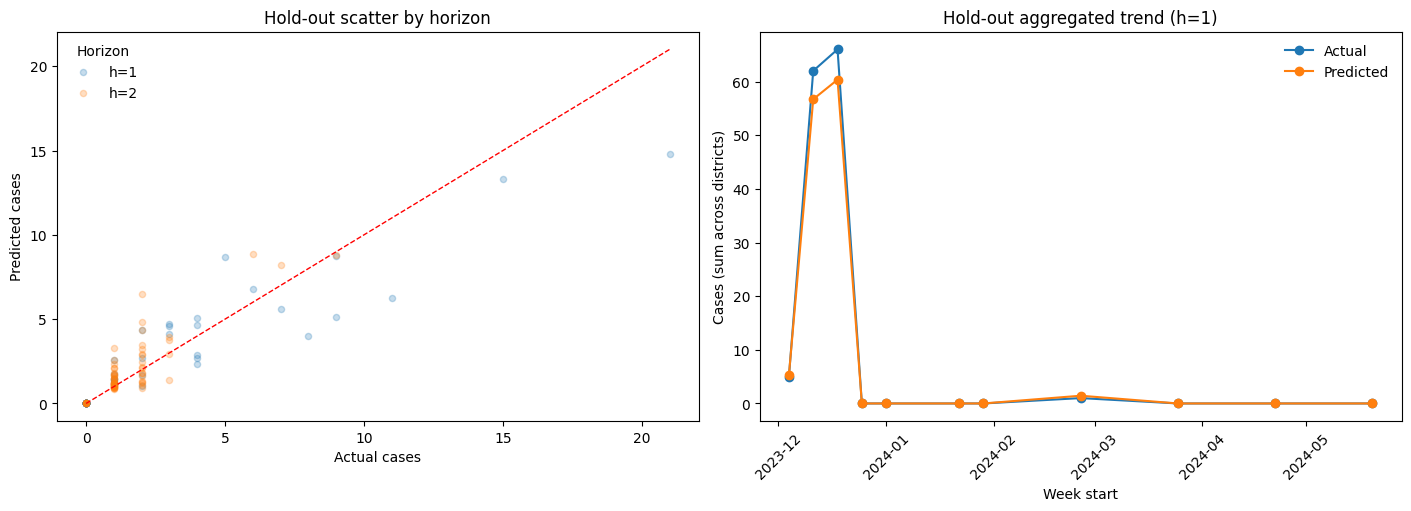

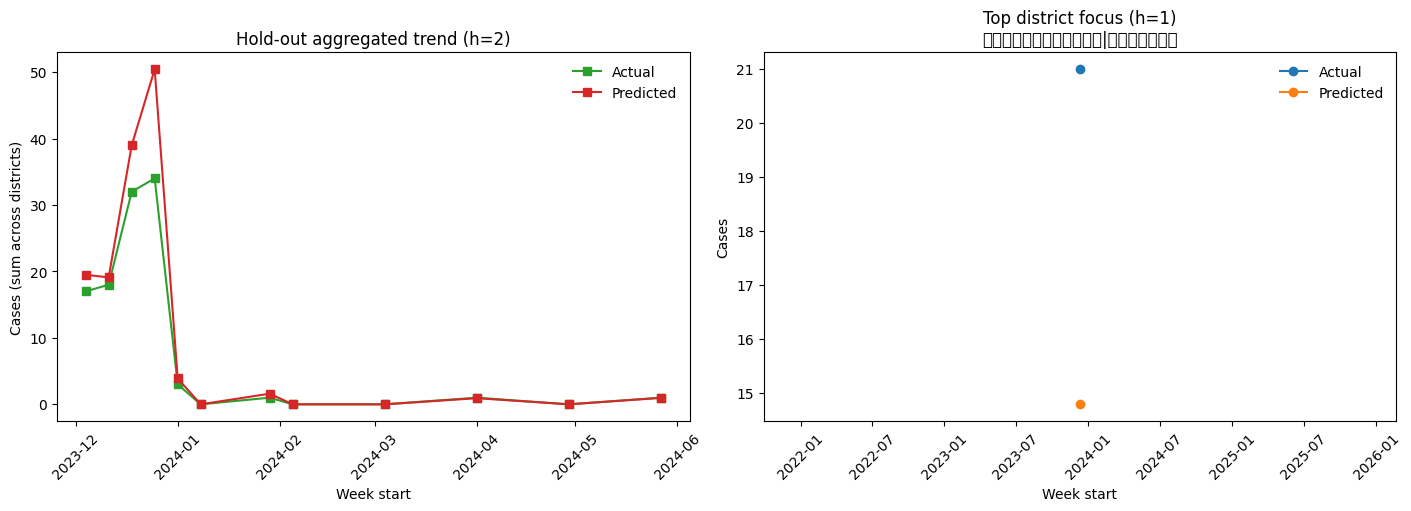

In [13]:
import matplotlib.pyplot as plt

viz_df = hold_predictions[["unique_id","ds","h","y","y_pred"]].copy()
viz_df["h_label"] = viz_df["h"].apply(lambda x: f"h={int(x)}")

unique_horizons = sorted(viz_df["h"].unique())
palette = {h: color for h, color in zip(unique_horizons, ["tab:blue","tab:orange","tab:green","tab:red"]) }

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# Scatter of actual vs predicted by horizon
y_min = float(viz_df[["y","y_pred"]].min().min())
y_max = float(viz_df[["y","y_pred"]].max().max())
for h_val in unique_horizons:
    sub = viz_df[viz_df["h"] == h_val]
    axes[0].scatter(sub["y"], sub["y_pred"], alpha=0.25, s=20, color=palette.get(h_val, "tab:gray"), label=f"h={int(h_val)}")
axes[0].plot([y_min, y_max], [y_min, y_max], linestyle="--", color="red", linewidth=1)
axes[0].set_xlabel("Actual cases")
axes[0].set_ylabel("Predicted cases")
axes[0].set_title("Hold-out scatter by horizon")
axes[0].legend(title="Horizon", frameon=False)

# Time-series comparison for h=1 aggregate
h1 = (viz_df[viz_df["h"] == 1]
       .groupby("ds", as_index=False)[["y","y_pred"]]
       .sum())
axes[1].plot(h1["ds"], h1["y"], marker="o", linewidth=1.5, label="Actual", color="tab:blue")
axes[1].plot(h1["ds"], h1["y_pred"], marker="o", linewidth=1.5, label="Predicted", color="tab:orange")
axes[1].set_title("Hold-out aggregated trend (h=1)")
axes[1].set_xlabel("Week start")
axes[1].set_ylabel("Cases (sum across districts)")
axes[1].tick_params(axis="x", rotation=45)
axes[1].legend(frameon=False)

plt.show()

# Additional horizon 2 aggregation and top-district spotlight
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

if 2 in unique_horizons:
    h2 = (viz_df[viz_df["h"] == 2]
           .groupby("ds", as_index=False)[["y","y_pred"]]
           .sum())
    axes[0].plot(h2["ds"], h2["y"], marker="s", linewidth=1.5, label="Actual", color="tab:green")
    axes[0].plot(h2["ds"], h2["y_pred"], marker="s", linewidth=1.5, label="Predicted", color="tab:red")
    axes[0].set_title("Hold-out aggregated trend (h=2)")
    axes[0].set_xlabel("Week start")
    axes[0].set_ylabel("Cases (sum across districts)")
    axes[0].tick_params(axis="x", rotation=45)
    axes[0].legend(frameon=False)
else:
    axes[0].axis("off")
    axes[0].text(0.5, 0.5, "No horizon 2 forecasts", ha="center", va="center")

h1_totals = (viz_df[viz_df["h"] == 1]
              .groupby("unique_id")["y"]
              .sum()
              .sort_values(ascending=False))
if not h1_totals.empty:
    top_id = h1_totals.index[0]
    top_series = (viz_df[(viz_df["unique_id"] == top_id) & (viz_df["h"] == 1)]
                  .sort_values("ds"))
    axes[1].plot(top_series["ds"], top_series["y"], marker="o", linewidth=1.5, label="Actual", color="tab:blue")
    axes[1].plot(top_series["ds"], top_series["y_pred"], marker="o", linewidth=1.5, label="Predicted", color="tab:orange")
    axes[1].set_title(f"Top district focus (h=1)\n{top_id}")
    axes[1].set_xlabel("Week start")
    axes[1].set_ylabel("Cases")
    axes[1].tick_params(axis="x", rotation=45)
    axes[1].legend(frameon=False)
else:
    axes[1].axis("off")
    axes[1].text(0.5, 0.5, "No h=1 records", ha="center", va="center")

plt.show()

In [17]:
import time
import contextlib
import io
from math import ceil

if 'df_all' not in globals():
    df_all = pd.concat([df_train, df_valid], ignore_index=True)

timing_input = df_all[["unique_id","ds","y"] + XCOLS].copy()
timing_input["ds"] = pd.to_datetime(timing_input["ds"])
timing_input = timing_input.sort_values(["unique_id","ds"]).reset_index(drop=True)

timing_windows = 1
timing_h = H
timing_step = H

tic = time.perf_counter()
stdout_buffer = io.StringIO()
with contextlib.redirect_stdout(stdout_buffer):
    timing_cv = fcst.cross_validation(
        df=timing_input,
        h=timing_h,
        n_windows=timing_windows,
        step_size=timing_step,
        refit=True,
        id_col="unique_id",
        time_col="ds",
        target_col="y",
        static_features=static_feats if len(static_feats) else None,
        dropna=True
    )
toc = time.perf_counter()

pred_col_timing = "Forecast" if "Forecast" in timing_cv.columns else forecast_col
timing_cv[pred_col_timing] = timing_cv[pred_col_timing].clip(lower=0)

pred_rows = len(timing_cv)
runtime = toc - tic
rows_per_sec = pred_rows / runtime if runtime > 0 else float("nan")

print(f"Single-window forecast runtime: {runtime:.2f} seconds for {pred_rows} predicted rows (h={timing_h}).")
print(f"Throughput ≈ {rows_per_sec:.2f} rows/second.")
timing_cv.head(3)

Single-window forecast runtime: 48.85 seconds for 142 predicted rows (h=2).
Throughput ≈ 2.91 rows/second.


,unique_id,ds,cutoff,y,lgb_poisson
0,None|ปทุมธานี,2023-11-20,2023-11-13,1,1.286404
1,None|ปทุมธานี,2023-11-27,2023-11-13,1,1.011661
2,คลองหลวง|ปทุมธานี,2023-12-18,2023-12-11,7,5.339249


In [14]:
# baseline = df_all[["unique_id","ds","y"]].copy()
# baseline = baseline.sort_values(["unique_id","ds"])

# baseline["y_lag1"] = baseline.groupby("unique_id")["y"].shift(1)
# baseline["y_lag2"] = baseline.groupby("unique_id")["y"].shift(2)

# baseline_h1 = baseline[baseline["ds"] >= cut_date].copy()
# baseline_h1["h"] = 1
# baseline_h1["y_pred"] = baseline_h1["y_lag1"].clip(lower=0)

# baseline_h2 = baseline[baseline["ds"] >= cut_date].copy()
# baseline_h2["h"] = 2
# baseline_h2["y_pred"] = baseline_h2["y_lag2"].clip(lower=0)

# baseline_all = pd.concat([baseline_h1, baseline_h2], ignore_index=True)
# baseline_all = baseline_all.dropna(subset=["y_pred"])

# def evaluate_baseline(frame: pd.DataFrame, horizon: int) -> dict:
#     sub = frame[frame["h"] == horizon]
#     y = sub["y"].to_numpy(dtype=float)
#     yhat = sub["y_pred"].to_numpy(dtype=float)
#     rmse = float(np.sqrt(np.mean((yhat - y)**2)))
#     mae = float(np.mean(np.abs(yhat - y)))
#     rmsle = float(np.sqrt(np.mean((np.log1p(np.maximum(yhat,0)) - np.log1p(np.maximum(y,0)))**2)))
#     denom = float(np.abs(y).sum()) + 1e-6
#     wape = float(np.abs(yhat - y).sum() / denom * 100)
#     if np.allclose(y.var(), 0):
#         r2 = np.nan
#     else:
#         ss_res = float(((y - yhat)**2).sum())
#         ss_tot = float(((y - y.mean())**2).sum())
#         r2 = float(1 - ss_res / (ss_tot + 1e-12))
#     return {"horizon": horizon, "RMSE": rmse, "MAE": mae, "RMSLE": rmsle, "WAPE": wape, "R2": r2}

# baseline_metrics = pd.DataFrame([evaluate_baseline(baseline_all, 1), evaluate_baseline(baseline_all, 2)])
# display(baseline_metrics)

In [15]:
import cloudpickle
from datetime import datetime

phase_dir = MODELS/"phase2_v2"
phase_dir.mkdir(parents=True, exist_ok=True)

artifact = {
    "created_utc": datetime.utcnow().isoformat() + "Z",
    "cut_date_valid": str(cut_date),
    "features": XCOLS,
    "static_features": static_feats,
    "extra_lags": extra_lags,
    "extra_rolls": extra_rolls,
    "diff_windows": diff_windows,
    "freq": "W-MON",
    "model_name": "lgb_poisson",
    "rng_seed": RNG_SEED,
    "notes": "v2 enhanced features + poisson objective"
}
with open(phase_dir/"fcst_model.pkl","wb") as f:
    cloudpickle.dump(fcst, f)
with open(phase_dir/"metadata.json","w",encoding="utf-8") as f:
    json.dump(artifact, f, ensure_ascii=False, indent=2)

print("Saved model →", phase_dir/"fcst_model.pkl")
print("Saved metadata →", phase_dir/"metadata.json")

/tmp/ipykernel_17526/4152598470.py:8: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_utc": datetime.utcnow().isoformat() + "Z",


Saved model → /teamspace/studios/this_studio/data/dengue/models/phase2_v2/fcst_model.pkl
Saved metadata → /teamspace/studios/this_studio/data/dengue/models/phase2_v2/metadata.json
